<a href="https://colab.research.google.com/github/bb2796/sample-repo/blob/main/PRML_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class GaussianMixture(object):

    def __init__(self, n_component):
        # ガウス分布の個数
        self.n_component = n_component

    # EMアルゴリズムを用いた最尤推定
    def fit(self, X, iter_max=10):
        # データの次元, Xの列
        self.ndim = np.size(X, 1)
        # 混合係数の初期化
        self.weights = np.ones(self.n_component) / self.n_component
        # 平均の初期化
        self.means = np.random.uniform(X.min(), X.max(), (self.ndim, self.n_component))
        # 共分散行列の初期化
        self.covs = np.repeat(10 * np.eye(self.ndim), self.n_component).reshape(self.ndim, self.ndim, self.n_component)

        # EステップとMステップを繰り返す
        for i in  range(iter_max):
            params = np.hstack((self.weights.ravel(), self.means.ravel(), self.covs.ravel()))
            print(self.means)
            # Eステップ、負担率を計算
            resps = self.expectation(X)
            # Mステップ、パラメータを更新
            self.maximization(X, resps)
            # パラメータが収束したかを確認
            if np.allclose(params, np.hstack((self.weights.ravel(), self.means.ravel(), self.covs.ravel()))):
                break
        else:
            print("parameters may not have converged")

    # ガウス関数
    def gauss(self, X):
        precisions = np.linalg.inv(self.covs.T).T #逆行列
        diffs = X[:, :, None] - self.means #中心との座標の差を計算
        assert diffs.shape == (len(X), self.ndim, self.n_component)
        exponents = np.sum(np.einsum('nik,ijk->njk', diffs, precisions) * diffs, axis=1)
        assert exponents.shape == (len(X), self.n_component)
        return np.exp(-0.5 * exponents) / np.sqrt(np.linalg.det(self.covs.T).T * (2 * np.pi) ** self.ndim)

    # Eステップ
    def expectation(self, X):
        # PRML式(9.23)
        resps = self.weights * self.gauss(X)
        resps /= resps.sum(axis=-1, keepdims=True)
        #print(f"resps:{resps.shape}")
        return resps

    # Mステップ
    def maximization(self, X, resps):
        # PRML式(9.27)
        Nk = np.sum(resps, axis=0)

        # PRML式(9.26)
        self.weights = Nk / len(X)

        # PRML式(9.24)
        self.means = X.T.dot(resps) / Nk

        diffs = X[:, :, None] - self.means
        # PRML式(9.25)
        self.covs = np.einsum('nik,njk->ijk', diffs, diffs * np.expand_dims(resps, 1)) / Nk

    # 確率分布p(x)を計算
    def predict_proba(self, X):
        # PRML式(9.7)
        gauss = self.weights * self.gauss(X)
        return np.sum(gauss, axis=-1)

    # クラスタリング
    def classify(self, X):
        joint_prob = self.weights * self.gauss(X)
        return np.argmax(joint_prob, axis=1)

In [3]:
def create_toy_data():
    x1 = np.random.normal(size=(100, 2))
    x1 += np.array([-5, -5])
    x2 = np.random.normal(size=(100, 2))
    x2 += np.array([5, -5])
    x3 = np.random.normal(size=(100, 2))
    x3 += np.array([0, 5])
    return np.vstack((x1, x2, x3))

[[ 2.37647599 -2.54999873 -5.82415793]
 [ 3.69458716  2.69953977 -1.58169071]]
[[ 3.03607285  0.40109356 -4.01511923]
 [-0.73810849  1.51531756 -4.89214498]]
[[ 2.9664165   0.68973783 -4.74058938]
 [-0.74008722  2.6469686  -5.0194482 ]]
[[ 3.00291103  0.6086189  -5.01116802]
 [-0.86287648  3.02187768 -5.00930488]]
[[ 3.0813771   0.36720829 -5.02238555]
 [-1.02722622  3.52464477 -5.00981964]]
[[ 3.21887926  0.0713389  -5.02238371]
 [-1.32549865  4.24981782 -5.00981973]]
[[ 3.50918369 -0.07966917 -5.02238242]
 [-1.9575409   4.81882275 -5.00981982]]
[[ 4.10582955 -0.03945893 -5.02238225]
 [-3.17208809  4.88214555 -5.00981981]]
[[ 4.54109279 -0.00701629 -5.02238225]
 [-4.07875023  4.89403044 -5.00981981]]
[[ 4.84560901  0.04451339 -5.02238225]
 [-4.75662813  4.87314717 -5.00981981]]
[[ 4.9244558   0.07717781 -5.02238225]
 [-4.95295956  4.84581564 -5.00981981]]
[[ 4.92446151  0.0771805  -5.02238225]
 [-4.95297405  4.84581315 -5.00981981]]


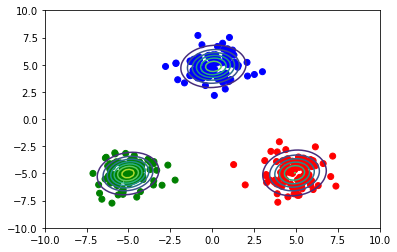

In [6]:
X = create_toy_data()
model = GaussianMixture(3)
model.fit(X, iter_max=100)
labels = model.classify(X)

x_test, y_test = np.meshgrid(np.linspace(-10, 10, 100), np.linspace(-10, 10, 100))
X_test = np.array([x_test, y_test]).reshape(2, -1).transpose()
probs = model.predict_proba(X_test)
Probs = probs.reshape(100, 100)
colors = ["red", "blue", "green"]
plt.scatter(X[:, 0], X[:, 1], c=[colors[int(label)] for label in labels])
plt.contour(x_test, y_test, Probs)
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.show()